# comparison of parameters and construction of the MINE database

Following resources are provided from MINEs (*Metabolic In silico Network Expansions*):
- paper MINEs database: <https://doi.org/10.1186/s13321-015-0087-1>
- paper Pickaxe: <https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-023-05149-8>
- documentation: <https://mine-database.readthedocs.io/en/latest/pickaxe_run.html#coreactant-and-rule-lists>
- github: <https://github.com/tyo-nu/MINE-Database>
- website: <https://minedatabase.mcs.anl.gov/#/home>

MINE Database works as follow:  
![alt <https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0087-1>](./doc/Mines_database_overview.png "MINEs database")


We like to use the database with Pickaxe, which is a integrated tool for predection of nouvelle molecules.  
![alt <https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-023-05149-8>](./doc/Pickaxe_overview.png "MINEs database")

Our molecules are from LOTUS <https://lotus.naturalproducts.net/>, the reaction rules we want to use from the MINEs database, what we will compare here. 
The expanding will be in the first run for one genereation.  
The filter in the moment are not realy interesting, because most of them using a "targetfilter", which means that specific molecules can be dropped.

## rulesets in MINEs

There are two rulesets availabel from pickaxe:  
- <https://github.com/commons-research/MINE-Database/tree/master/mine_database/data/metacyc_rules/metacyc_generalized_rules.tsv> **(1224 rules)**
- <https://github.com/commons-research/MINE-Database/tree/master/mine_database/data/metacyc_rules/metacyc_intermediate_rules.tsv> **(7358 rules)**

The paper explains the generalized rules:  
"The provided rules, known as JN1224min, consist of 1224 generalized rules that represent a minimal, yet comprehensive, ruleset that maps MetaCyc reactions. "  
![alt <https://www.sciencedirect.com/science/article/pii/S1096717621000288?via%3Dihub>](./doc/JN1224min_ruleset_explained.png "rulset comparison")


This known rules were investigated in this paper: <https://doi.org/10.1016/j.ymben.2021.02.006>
"These reaction rules were capable of reproducing more than 85% of all reactions in the KEGG and BRENDA databases, for which a large fraction of reactions is not present in MetaCyc."

![alt <https://www.sciencedirect.com/science/article/pii/S1096717621000288?via%3Dihub>](./doc/database_rulesets_and_reactions.png "database comparison")

In [1]:
# load modules
import sys
import polars as pl
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import seaborn as sns
import itertools

sns.set(rc={'figure.figsize':(8,6)}, style="whitegrid")

In [2]:
df_intermediate_rules = pl.read_csv("../MINE-Database/mine_database/data/metacyc_rules/metacyc_intermediate_rules.tsv", separator="\t", truncate_ragged_lines=True)
df_generalized_rules = pl.read_csv("../MINE-Database/mine_database/data/metacyc_rules/metacyc_generalized_rules.tsv", separator="\t", truncate_ragged_lines=True)

print("intermediate rules", df_intermediate_rules.shape, df_intermediate_rules.head())
print("generalized rules", df_generalized_rules.shape, df_generalized_rules.head())

intermediate rules (7358, 7) shape: (5, 7)
┌─────────────┬───────────────┬──────────────┬──────────────┬──────────────┬────────┬──────────────┐
│ Name        ┆ Reactants     ┆ SMARTS       ┆ Products     ┆ Comments     ┆ counts ┆ Uniprot      │
│ ---         ┆ ---           ┆ ---          ┆ ---          ┆ ---          ┆ ---    ┆ ---          │
│ str         ┆ str           ┆ str          ┆ str          ┆ str          ┆ i64    ┆ str          │
╞═════════════╪═══════════════╪══════════════╪══════════════╪══════════════╪════════╪══════════════╡
│ rule0012_18 ┆ Any;Any       ┆ [#6;$([#6&!R ┆ Any;WATER    ┆ brenda:3.4.1 ┆ 989    ┆ A1S3N8;AB009 │
│             ┆               ┆ ](-&!@[#6&!R ┆              ┆ 1.4_00;brend ┆        ┆ 494;AKR1C2;A │
│             ┆               ┆ ]-&!@[#7…    ┆              ┆ a:3.4.11…    ┆        ┆ LDH3A1;A…    │
│ rule0003_13 ┆ NADH_CoF;Any  ┆ [#6:1]1=[#6: ┆ Any;NAD_CoF  ┆ brenda:1.1.1 ┆ 424    ┆ A0A017H563;A │
│             ┆               ┆ 2]-[#7:3]-[# ┆  

The first look at the two rulsets shows us different sizes of the shape. Not only the ammount of rules, also the columns.  
The intermediate rules have additionaly columns of "counts" (number of comments seperated with ;) and "Uniprot" (enzymcode). The "Comments" are the reactionnames from other databases.  
The "Comments" in the generalized rules are the same as the "Uniprot" in the intermediate rules. 

In [3]:
# calculate the amount of the entries in the first comment in intermediate rules
comments_intermediate = df_intermediate_rules["Comments"][0].split(";")

# get the original value
counts_intermediate = df_intermediate_rules["counts"][0]

# print the amount of entries and compare them with the original rule
print(f"Counts of the first comment in the intermediat rules: {len(comments_intermediate)} \nSame as original values: {counts_intermediate == len(comments_intermediate)}")

Counts of the first comment in the intermediat rules: 989 
Same as original values: True


In [4]:
# Check the SMARTS, if they are all unique
unique_counts_intermediate = df_intermediate_rules.unique(subset=["SMARTS"], maintain_order = True).count()
unique_counts_generalized = df_generalized_rules.unique(subset=["SMARTS"], maintain_order = True).count()
reaction_size_intermediate = df_intermediate_rules.shape[0]
reaction_size_generalized = df_generalized_rules.shape[0]

# show the difference to the original dataset)
print("intermediate dataframe", df_intermediate_rules.shape[0], unique_counts_intermediate.select(["SMARTS"]).item(), f'difference: {reaction_size_intermediate - unique_counts_intermediate.select(["SMARTS"]).item()}',
    "\ngeneralized dataframe", df_generalized_rules.shape[0], unique_counts_generalized.select(["SMARTS"]).item(), f'difference: {reaction_size_generalized - unique_counts_generalized.select(["SMARTS"]).item()}',
    sep="\n")

intermediate dataframe
7358
7323
difference: 35

generalized dataframe
1224
1032
difference: 192


The field SMARTS are in both rulesetst not unique, what is not what I expected.  
It shows, that if we only try to look at the SMARTS, we see that we have some duplicates.  
Because of that, further investigations are done with the colum "Name" compared to their content.

In [12]:
df_gen_rules_without_name = df_generalized_rules.select(["Reactants", "SMARTS", "Products"]).unique()
df_interm_rules_without_name = df_intermediate_rules.select(["Reactants", "SMARTS", "Products"]).unique()

joined_df_reactants_smarts_products = df_gen_rules_without_name.join(df_interm_rules_without_name, on=["Reactants", "SMARTS", "Products"], how="inner")
joined_df_reactants_smarts = df_intermediate_rules.select(["Reactants", "SMARTS"]).join(df_generalized_rules.select(["Reactants", "SMARTS"]), on=["Reactants", "SMARTS"], how="inner")
joined_df_smarts = df_intermediate_rules.select(["SMARTS"]).join(df_generalized_rules.select(["SMARTS"]), on=["SMARTS"], how="inner")
joined_df_name = df_intermediate_rules.select(["Name"]).join(df_generalized_rules.select(["Name"]), on=["Name"], how="inner")

print(f"""--- equal entries found in generalized and intermediate ---
    \nunique rules in generalized ["Reactants", "SMARTS", "Products"]: {df_gen_rules_without_name.shape[0]}
    \nunique rules in intermediate ["Reactants", "SMARTS", "Products"]: {df_interm_rules_without_name.shape[0]}
    \n["Reactants", "SMARTS", "Products"]: {joined_df_reactants_smarts_products.shape[0]} 
    \n["Reactants", "SMARTS"]: {joined_df_reactants_smarts.shape[0]} 
    \n["SMARTS"]: {joined_df_smarts.shape[0]}
    \n["Name"]: {joined_df_name.shape[0]}""")


df_generalized_rules.join(df_intermediate_rules, on=["Name", "Reactants", "SMARTS", "Products"], how="inner").shape

--- equal entries found in generalized and intermediate ---
    
unique rules in generalized ["Reactants", "SMARTS", "Products"]: 1224
    
unique rules in intermediate ["Reactants", "SMARTS", "Products"]: 7358
    
["Reactants", "SMARTS", "Products"]: 615 
    
["Reactants", "SMARTS"]: 641 
    
["SMARTS"]: 738
    
["Name"]: 476


(421, 8)

We have an overlap of 615 with the three columns. With less "features" the overlap is getting smaller.
This is expected. What is not expected is that the reaction name changes.  
From the first look at the dataset, it seems like they used the same names.

In [93]:
def plot_venn(datasets, labels, save_file=None, title_plot=None, **kwargs):
    """function for venn plot with 3 or 2 subsets.

    Different datasets would be compared and visualized for their similarity and difference.
    This is done automatically. The datasets would be compared line by line.

    Args:
        datasets (list): datasets for comparison
        labels (list): labelnames for datasets
        save_file (str): path and filename to save the figure

    Returns:
        object: The diagramm will be returned
    """

    
    # check, how many datasets are there. 
    if len(datasets) == 0:
        raise ValueError('Programm ended because of no datasets added!')

    # if the datasize is bigger then 3, stop the function (better upset plot)
    elif len(datasets) > 3:
        raise ValueError('Venn diagramm is not able to handle more than 3 datasets! Please use upset plot.')

    # check if labels and datasets have the same length!
    if len(labels) != len(datasets):
        raise ValueError('Labels and datasets have not the same length. Please provide this two lists with the same length.')
    
    # Check if datasets have the same number of features
    n_features = [dataset.shape[1] for dataset in datasets]
    if len(set(n_features)) != 1:
        raise ValueError('Datasets have different numbers of features. Please check and try again.')

    
    if len(datasets) == 2:
        sizes = dict()
        # Process the data and calculate the similarities and differences
        sizes['11'] = datasets[0].join(datasets[1], on=datasets[1].columns, how="inner").shape[0]
        sizes['10'] = datasets[0].shape[0] - sizes['11']
        sizes['01'] = datasets[1].shape[0] - sizes['11']
        sizes['00'] = datasets[0].join(datasets[1], on=datasets[1].columns, how="outer").shape[0] - sizes['10'] - sizes['01'] - sizes['11']
    
        # Plot Venn diagram
        venn_plot = venn2(subsets=(sizes['10'], sizes['01'], sizes['11']), set_labels=labels, **kwargs)

        if title_plot is None:
            plt.title(f"2-Set Venn Diagram")
        else:
            plt.title(title_plot)

    
    if len(datasets) == 3:
        sizes = dict()
        # Process the data and calculate the similarities and differences
        sizes['111'] = datasets[0].join(datasets[1], on=datasets[1].columns, how="inner").join(datasets[2], on=datasets[2].columns, how="inner").shape[0]
        sizes['110'] = datasets[0].join(datasets[1], on=datasets[1].columns, how="inner").shape[0] - sizes['111']
        sizes['101'] = datasets[0].join(datasets[2], on=datasets[2].columns, how="inner").shape[0] - sizes['111']
        sizes['011'] = datasets[1].join(datasets[2], on=datasets[2].columns, how="inner").shape[0] - sizes['111']
        sizes['100'] = datasets[0].shape[0] - sizes['111'] - sizes['110'] - sizes['101']
        sizes['010'] = datasets[1].shape[0] - sizes['111'] - sizes['110'] - sizes['011']
        sizes['001'] = datasets[1].shape[0] - sizes['111'] - sizes['011'] - sizes['101']
        # sizes['000'] = datasets[0].join(datasets[1], on=datasets[1].columns, how="outer").shape[0] - sizes['111'] - sizes['110'] - sizes['101'] - sizes['011']

        # # Plot Venn diagram
        venn_plot = venn3(subsets=(sizes['100'], sizes['010'], sizes['110'], sizes['001'], sizes['101'], sizes['011'], sizes['111']), set_labels=labels, **kwargs)

        if title_plot is None:
            plt.title(f"3-Set Venn Diagram")
        else:
            plt.title(title_plot)

    if save_file is not None:
        plt.savefig(save_file)
    else:
        plt.plot()

    return venn_plot

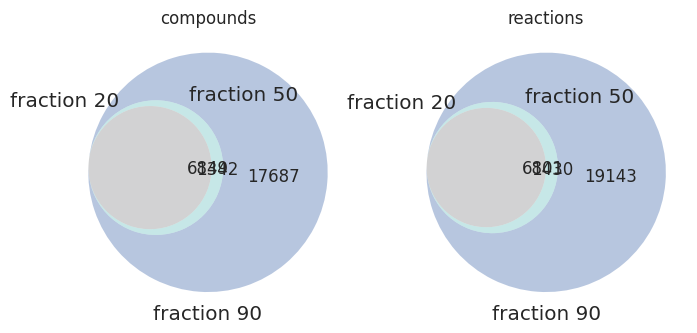

reactions:  6801 8231 27374
compounds:  6849 8191 25878


In [171]:
df_intermediate_compounds_20 = pl.read_csv("../MINE-Database/data/output/metacyc_intermediate/compounds_20.tsv", separator='\t')
df_intermediate_compounds_50 = pl.read_csv("../MINE-Database/data/output/metacyc_intermediate/compounds_50.tsv", separator='\t')
df_intermediate_compounds_90 = pl.read_csv("../MINE-Database/data/output/metacyc_intermediate/compounds_90.tsv", separator='\t')


df_intermediate_compounds_20 = df_intermediate_compounds_20.filter(pl.col('Type') == "Predicted")
df_intermediate_compounds_50 = df_intermediate_compounds_50.filter(pl.col('Type') == "Predicted")
df_intermediate_compounds_90 = df_intermediate_compounds_90.filter(pl.col('Type') == "Predicted")


# select an unique identifier: 'ID', 'Type', 'Generation', 'Formula', 'InChIKey', 'SMILES'
df_intermediate_compounds_20_set = set(df_intermediate_compounds_20['InChIKey'].to_list())
df_intermediate_compounds_50_set = set(df_intermediate_compounds_50['InChIKey'].to_list())
df_intermediate_compounds_90_set = set(df_intermediate_compounds_90['InChIKey'].to_list())


df_intermediate_reactions_20 = pl.read_csv("../MINE-Database/data/output/metacyc_intermediate/reactions_20.tsv", separator='\t')
df_intermediate_reactions_50 = pl.read_csv("../MINE-Database/data/output/metacyc_intermediate/reactions_50.tsv", separator='\t')
df_intermediate_reactions_90 = pl.read_csv("../MINE-Database/data/output/metacyc_intermediate/reactions_90.tsv", separator='\t')

# select an unique identifier: 'ID', 'Name', 'ID equation', 'SMILES equation', 'Rxn hash', 'Reaction rules'
df_intermediate_reactions_20_set = set(df_intermediate_reactions_20['Rxn hash'].to_list())
df_intermediate_reactions_50_set = set(df_intermediate_reactions_50['Rxn hash'].to_list())
df_intermediate_reactions_90_set = set(df_intermediate_reactions_90['Rxn hash'].to_list())

# plot for visualistation
plt.subplot(1, 2, 1) # row 1, col 2 index 1
venn3([df_intermediate_compounds_20_set, df_intermediate_compounds_50_set, df_intermediate_compounds_90_set], set_labels=["fraction 20", "fraction 50", "fraction 90"])
plt.title("compounds")

plt.subplot(1, 2, 2) # index 2
venn3([df_intermediate_reactions_20_set, df_intermediate_reactions_50_set, df_intermediate_reactions_90_set], set_labels=["fraction 20", "fraction 50", "fraction 90"])
plt.title("reactions")

plt.show()

print("reactions: ",len(df_intermediate_reactions_20_set), len(df_intermediate_reactions_50_set), len(df_intermediate_reactions_90_set))
print("compounds: ",len(df_intermediate_compounds_20_set), len(df_intermediate_compounds_50_set), len(df_intermediate_compounds_90_set))

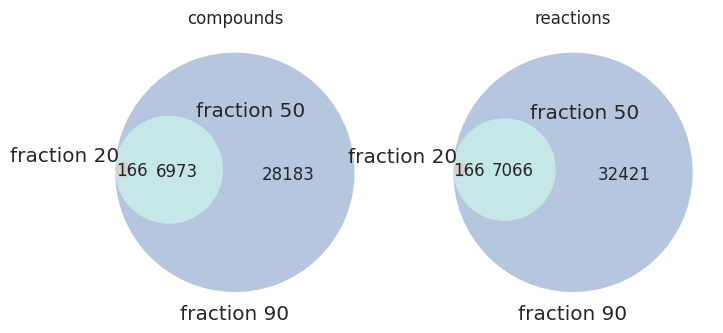

In [164]:
df_generalized_compounds_20 = pl.read_csv("../MINE-Database/data/output/metacyc_generalized/compounds_20.tsv", separator='\t')
df_generalized_compounds_50 = pl.read_csv("../MINE-Database/data/output/metacyc_generalized/compounds_50.tsv", separator='\t')
df_generalized_compounds_90 = pl.read_csv("../MINE-Database/data/output/metacyc_generalized/compounds_90.tsv", separator='\t')

df_generalized_compounds_20 = df_generalized_compounds_20.filter(pl.col('Type') == "Predicted")
df_generalized_compounds_50 = df_generalized_compounds_50.filter(pl.col('Type') == "Predicted")
df_generalized_compounds_90 = df_generalized_compounds_90.filter(pl.col('Type') == "Predicted")

# select an unique identifier: 'ID', 'Type', 'Generation', 'Formula', 'InChIKey', 'SMILES'
df_generalized_compounds_20_set = set(df_generalized_compounds_20['InChIKey'].to_list())
df_generalized_compounds_50_set = set(df_generalized_compounds_50['InChIKey'].to_list())
df_generalized_compounds_90_set = set(df_generalized_compounds_90['InChIKey'].to_list())


df_generalized_reactions_20 = pl.read_csv("../MINE-Database/data/output/metacyc_generalized/reactions_20.tsv", separator='\t')
df_generalized_reactions_50 = pl.read_csv("../MINE-Database/data/output/metacyc_generalized/reactions_50.tsv", separator='\t')
df_generalized_reactions_90 = pl.read_csv("../MINE-Database/data/output/metacyc_generalized/reactions_90.tsv", separator='\t')

# select an unique identifier: 'ID', 'Name', 'ID equation', 'SMILES equation', 'Rxn hash', 'Reaction rules'
df_generalized_reactions_20_set = set(df_generalized_reactions_20['Rxn hash'].to_list())
df_generalized_reactions_50_set = set(df_generalized_reactions_50['Rxn hash'].to_list())
df_generalized_reactions_90_set = set(df_generalized_reactions_90['Rxn hash'].to_list())

# plot for visualistation
plt.subplot(1, 2, 1) # row 1, col 2 index 1
venn3([df_generalized_compounds_20_set, df_generalized_compounds_50_set, df_generalized_compounds_90_set], set_labels=["fraction 20", "fraction 50", "fraction 90"])
plt.title("compounds")

plt.subplot(1, 2, 2) # index 2
venn3([df_generalized_reactions_20_set, df_generalized_reactions_50_set, df_generalized_reactions_90_set], set_labels=["fraction 20", "fraction 50", "fraction 90"])
plt.title("reactions")

plt.show()